In [1]:
 from google.colab import drive
 drive.mount('/content/drive') 
import os

os.chdir('/content/drive/My Drive/GR5205 GU4205 Linear Regression Models Team Project')
os.getcwd()

ModuleNotFoundError: No module named 'google'

In [64]:

import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import jarque_bera, durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

ts_df = pd.read_csv('./BTC_3.csv')
ts_df = ts_df.dropna()

#scale BTC Volume
ts_df['BTC Volume'] = ts_df['BTC Volume']/1000000

#remove an outlier
#outlier is defined as a max in this content
ts_df = ts_df[ts_df['BTC Volume']!=ts_df['BTC Volume'].max()]

#predictors
X = ts_df[['BTC Volume','NVDA',]]

#response
response = 'BTC Close'
y = ts_df[response]



                            OLS Regression Results                            
Dep. Variable:              BTC Close   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     84.22
Date:                Tue, 02 May 2023   Prob (F-statistic):           9.04e-19
Time:                        11:37:00   Log-Likelihood:                -5985.6
No. Observations:                 549   AIC:                         1.198e+04
Df Residuals:                     547   BIC:                         1.198e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.437e+04   1407.052     17.322      0.0

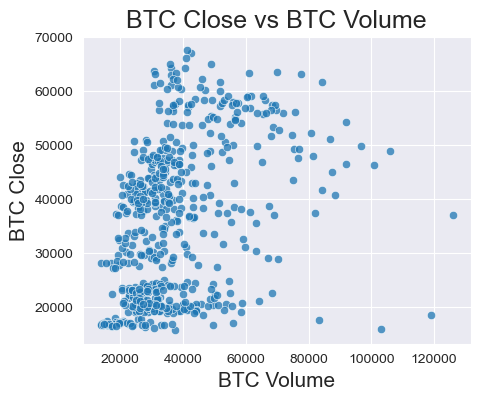

In [65]:

#simple linear regression
predictor_slr = 'BTC Volume'
X_slr = ts_df[predictor_slr]
X_slr_ac = sm.add_constant(X_slr)
model_slr = sm.OLS(y, X_slr_ac).fit()
print(model_slr.summary())
residuals_slr = model_slr.resid
fitted_values_slr = model_slr.fittedvalues

plt.figure(figsize=(5, 4)) # (width, height)
sns.scatterplot(x=X_slr, y=y, alpha=0.75) # alpha for transparency
plt.title(f'{response} vs {predictor_slr}', fontsize=18)
plt.xlabel(predictor_slr, fontsize=15)
plt.ylabel(response, fontsize=15)
plt.show()

In [66]:
from sklearn.metrics import mean_squared_error,r2_score
back_df = pd.read_csv('./BTC_backtest.csv')
back_df=back_df[["Date","BTC Close","BTC Volume","Bitcoin My Wallet Number of Transaction Per Day","NVDA","Ethereum","DJI"]]
back_df = back_df.dropna()

#scale BTC Volume
back_df['BTC Volume'] = back_df['BTC Volume']/1000000

#remove an outlier
#outlier is defined as a max in this content
back_df = back_df[back_df['BTC Volume']!=back_df['BTC Volume'].max()]

#predictors
XX = back_df[['BTC Volume','NVDA',]]

#response
response = 'BTC Close'
y_test = back_df[response]


In [70]:
#simple linear regression
predictor_slr = 'BTC Volume'
XX_slr = back_df[predictor_slr]
XX_slr_ac = sm.add_constant(XX_slr)
y_pred=model_slr.predict(XX_slr_ac)

mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("MSE:",mse)
print("R-squared",r2)

MSE: 183244775.98161814
R-squared -7792426467936.212


The MSE is significantly large and R-squared significantly negative, which represents OLS is useless regarding the backtested data

In [71]:
from statsmodels.tsa.arima.model import ARIMA
def ar1_covariance_matrix(N,rho,sigma2):  
    covariance_matrix=np.zeros((N,N))
    for i in range(N):
        for j in range(i+1):
            x=sigma2*(rho**abs(i-j))
            covariance_matrix[i,j]=x
            covariance_matrix[j,i]=x
    return covariance_matrix

In [72]:
import numpy as np

In [73]:
data=residuals_slr
N=len(data)
ar1_model=ARIMA(data,order=(1,0,0)).fit()
rho=ar1_model.params[1]
residuals=ar1_model.resid
sigma2=np.var(residuals)
covariance_matrix=ar1_covariance_matrix(N,rho,sigma2)

C:\Users\Augus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Augus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Augus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [74]:
myGLS=sm.GLS(y,X_slr_ac,sigma=covariance_matrix).fit()
print(myGLS.summary())

                            GLS Regression Results                            
Dep. Variable:              BTC Close   R-squared:                       0.011
Model:                            GLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     6.316
Date:                Tue, 02 May 2023   Prob (F-statistic):             0.0123
Time:                        11:38:48   Log-Likelihood:                -4880.4
No. Observations:                 549   AIC:                             9765.
Df Residuals:                     547   BIC:                             9773.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.665e+04   1634.116     22.425      0.0

In [76]:

y_pred=myGLS.predict(XX_slr_ac)

mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("MSE:",mse)
print("R-squared",r2)


MSE: 611316695.0762049
R-squared -7617931663043001.0


The MSE is significantly large and R-squared significantly negative, which represents OLS is useless regarding the backtested data

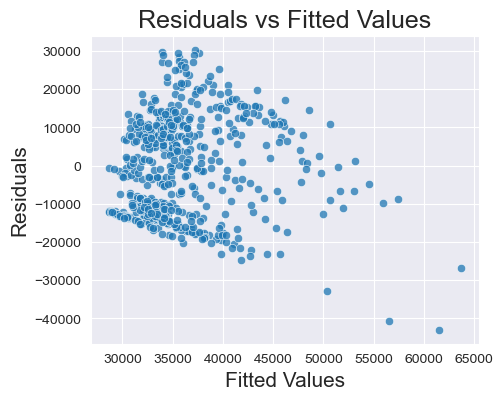

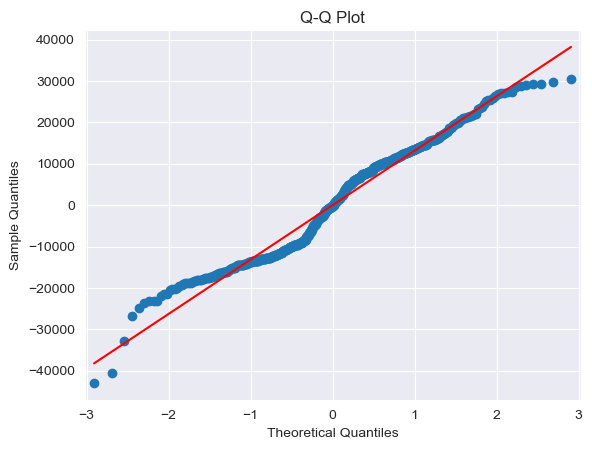

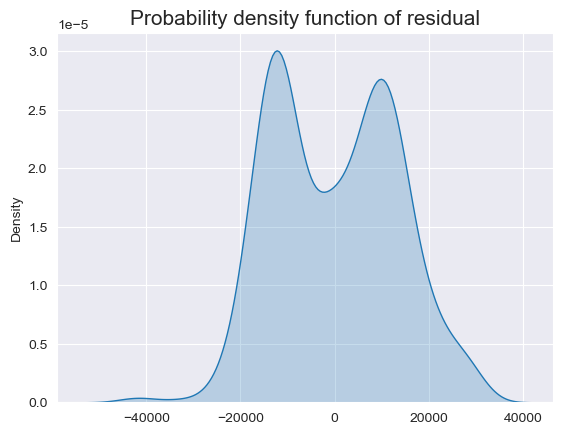

(12.353420144313962, 0.0020772506299515064, 0.06282379073008758, 2.2759468871959387)
0.0869422911080355
(266.9166630432243, 5.332405412153214e-60)


In [77]:
#check linearity between residuals and fitted values
plt.figure(figsize=(5, 4)) # (width, height)
sns.scatterplot(x=fitted_values_slr, y=residuals_slr, alpha=0.75) # alpha for transparency
plt.title('Residuals vs Fitted Values', fontsize=18)
plt.xlabel('Fitted Values', fontsize=15)
plt.ylabel('Residuals', fontsize=15)
plt.show()

#check normality of residuals
#using Quantile-Quantile plot
fig = sm.qqplot(residuals_slr, line='s')
plt.title('Q-Q Plot')
plt.show()

residuals_slr_np = residuals_slr.to_numpy()
sns.kdeplot(residuals_slr_np.reshape(-1), shade=True)
plt.title('Probability density function of residual', fontsize=15)
plt.show()

jbtest = jarque_bera(residuals_slr)
print(jbtest)

#check autocorrelation
dwtest = durbin_watson(residuals_slr)
print(dwtest)

# Run the Breusch-Pagan test to check homoscedasticity 
bptest = het_breuschpagan(residuals_slr, X)
print(bptest[0:2])





In [78]:
#multiple linear regression
X_ac = sm.add_constant(X)
model_mlr = sm.OLS(y, X_ac).fit()
print(model_mlr.summary())
residuals_mlr = model_mlr.resid
fitted_values_mlr = model_mlr.fittedvalues




                            OLS Regression Results                            
Dep. Variable:              BTC Close   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     197.2
Date:                Tue, 02 May 2023   Prob (F-statistic):           3.53e-65
Time:                        11:39:13   Log-Likelihood:                -5875.7
No. Observations:                 549   AIC:                         1.176e+04
Df Residuals:                     546   BIC:                         1.177e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.247e+04   2525.536     -4.939      0.0

In [79]:
#multi linear regression backtesting
XX_ac = sm.add_constant(XX)
y_pred=model_mlr.predict(XX_ac)

mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("MSE:",mse)
print("R-squared",r2)

MSE: 123358915.5786181
R-squared -5.396635482223013


In [80]:
data=residuals_mlr
N=len(data)
ar1_model=ARIMA(data,order=(1,0,0)).fit()
rho=ar1_model.params[1]
residuals=ar1_model.resid
sigma2=np.var(residuals)
covariance_matrix=ar1_covariance_matrix(N,rho,sigma2)

C:\Users\Augus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Augus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Augus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [81]:
myGLS=sm.GLS(y,X_ac,sigma=covariance_matrix).fit()
print(myGLS.summary())

                            GLS Regression Results                            
Dep. Variable:              BTC Close   R-squared:                       0.125
Model:                            GLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     39.12
Date:                Tue, 02 May 2023   Prob (F-statistic):           1.33e-16
Time:                        11:39:46   Log-Likelihood:                -5020.1
No. Observations:                 549   AIC:                         1.005e+04
Df Residuals:                     546   BIC:                         1.006e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.833e+04   2193.495      8.358      0.0

In [82]:
#GLS backtest


XX_ac = sm.add_constant(XX)
y_pred=myGLS.predict(XX_ac)

mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("MSE:",mse)
print("R-squared",r2)


MSE: 253026002.91405228
R-squared -38.1032012585678


The MSE is significantly large and R-squared significantly negative, which represents OLS is useless regarding the backtested data

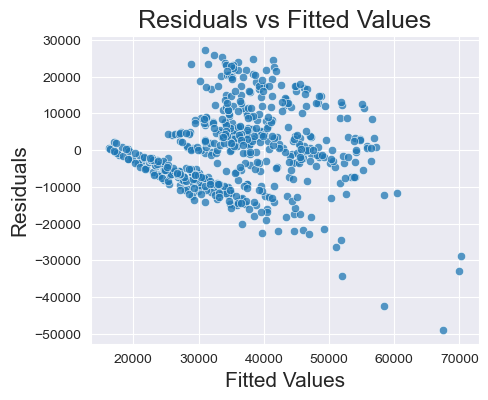

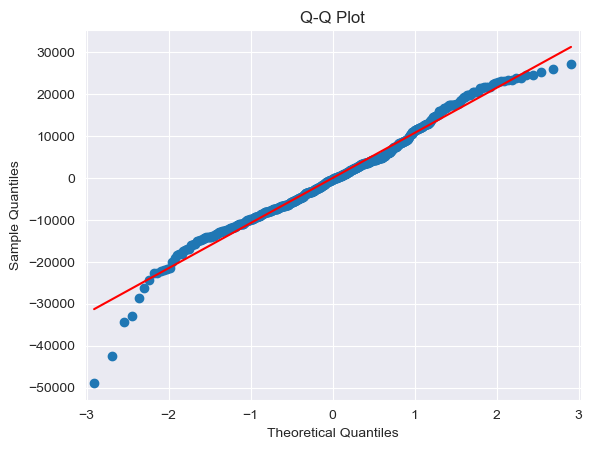

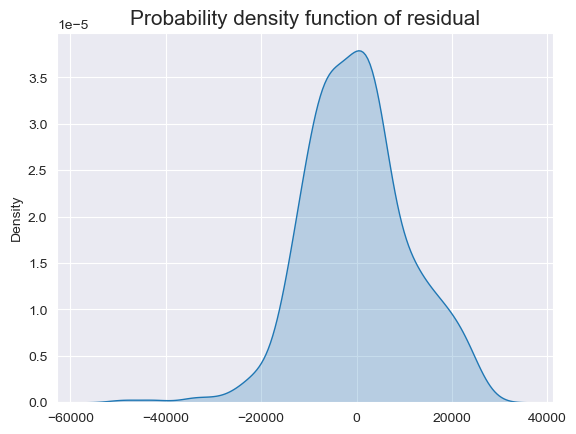

(19.060077509163538, 7.263680892875279e-05, -0.0772529570267526, 3.8996417923913227)
0.2584678857403605
(240.37542636709864, 3.257212415780591e-54)


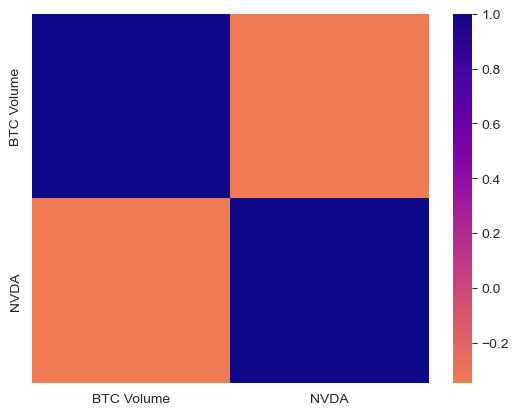

[11.855501473771849, 28.4831277778394, 59.715870776890625, 44.53107017845228, 23.331889966696725]


In [83]:
#check linearity between residuals and fitted values
plt.figure(figsize=(5, 4)) # (width, height)
sns.scatterplot(x=fitted_values_mlr, y=residuals_mlr, alpha=0.75) # alpha for transparency
plt.title('Residuals vs Fitted Values', fontsize=18)
plt.xlabel('Fitted Values', fontsize=15)
plt.ylabel('Residuals', fontsize=15)
plt.show()

#check normality of residuals
#using Quantile-Quantile plot
fig = sm.qqplot(residuals_mlr, line='s')
plt.title('Q-Q Plot')
plt.show()

residuals_mlr_np = residuals_mlr.to_numpy()
sns.kdeplot(residuals_mlr_np.reshape(-1), shade=True)
plt.title('Probability density function of residual', fontsize=15)
plt.show()

jbtest = jarque_bera(residuals_mlr)
print(jbtest)

#check autocorrelation
dwtest = durbin_watson(residuals_mlr)
print(dwtest)

# Run the Breusch-Pagan test to check homoscedasticity 
bptest = het_breuschpagan(residuals_mlr, X)
print(bptest[0:2])

#check multicollinearity
sns.heatmap(X.corr(),center=0, cmap='plasma_r')
plt.show()


predictors = ts_df.columns[2:]
X_2 = ts_df[predictors]
vif = [variance_inflation_factor(X_2.values,i)for i in range(X_2.shape[1])]
print(vif)